E:/Projekty/UFA/
Celkový počet súborov v priečinku: 16
	E126_mag.txt
	E126_start.txt
	E126_time.txt
	E5_mag.txt
	E5_start.txt
	E5_time.txt
	output
E:/Projekty/UFA/
Celkový počet meraní v priečinku: 2
	E5
	E126

 ____________________________________________________________ 

Čas začiatku merania:
	2015-11-04T13:09:04.074.702.590

Poče časových údajov		=	240001
Poče magnetických údajov	=	240001


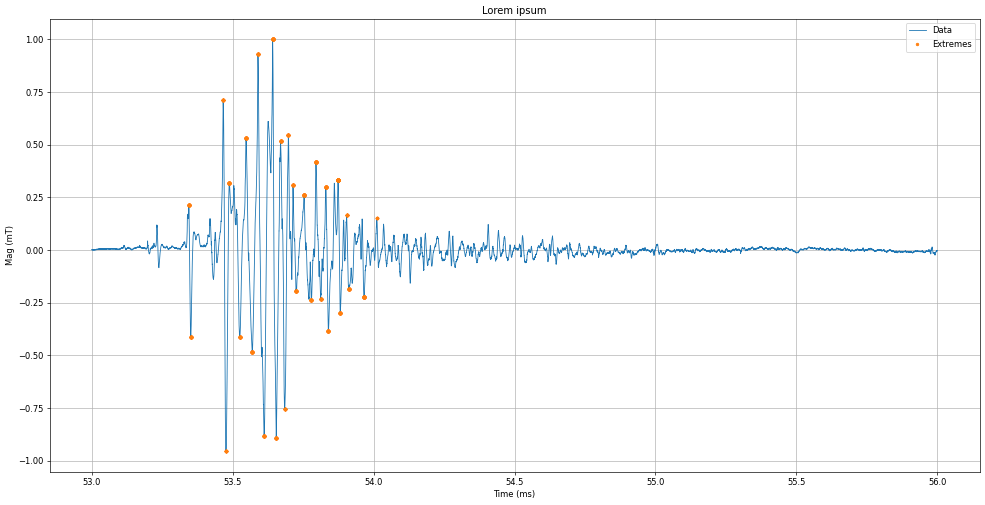

Čas začiatku merania:
	2015-10-13T22:09:30.072.857.595

Poče časových údajov		=	240001
Poče magnetických údajov	=	240001


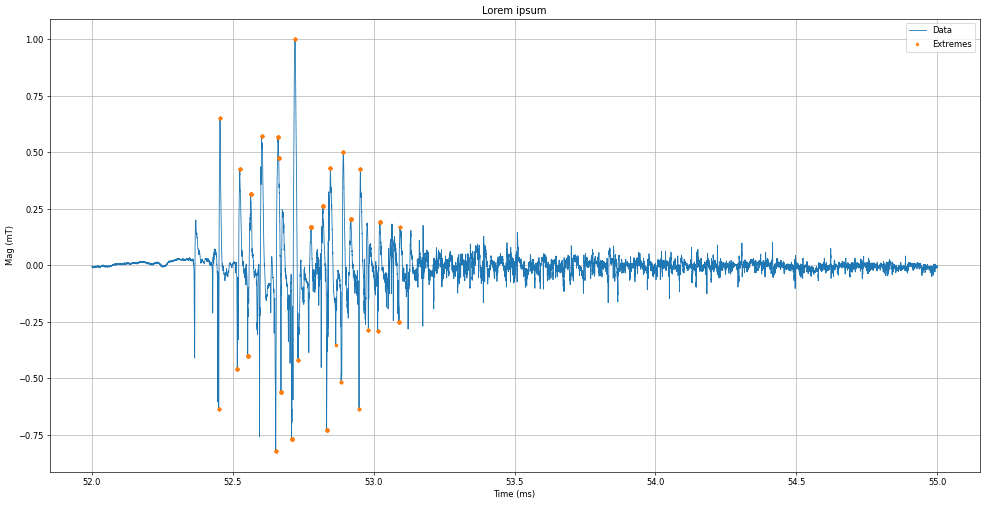

In [1]:
#Načítanie knižníc

from math import *
import os as os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

######################################################

directory = "E:/Projekty/UFA/"

#Všetky parametre využívané na nastavenie vyhľadávania

gauss_data = 801
gauss_dot1 = 201
gauss_dot2 = 101

basic_mode = True
basic_find = None
basic_triggp = 0.15
basic_triggm = -0.15
basic_trigg = 0.20
basic_radius = 1000
basic_binn_data = 100
basic_binn_dot1 = 10
basic_binn_dot2 = 5

######################################################

#Načíta časový údaj začiatku merania


def cas_udaj(file_start):
    start = open(file_start, "r")
    print("Čas začiatku merania:")
    print("\t" + start.readline())


#Načítanie súborov "time" a "mag" do listu a vypíše počet údajov v nich,
#následne ich zmení do np.array


def time_udaj(file_time):
    time = open(file_time, "r")
    time = time.readlines()
    print("Poče časových údajov\t\t=\t" + str(len(time)))
    time = np.array(time, dtype=np.float64)

    return time


def mag_udaj(file_mag):
    mag = open(file_mag, "r")
    mag = mag.readlines()
    print("Poče magnetických údajov\t=\t" + str(len(mag)))
    mag = np.array(mag, dtype=np.float64)

    return mag


#Normuje údaje


def normuj(zaznam):
    zaznam_max = np.nanmax(np.abs(zaznam))
    zaznam_norm = np.divide(zaznam, zaznam_max)
    return zaznam_norm


#Vyhladzovanie kĺzavým priemerom //Ja viem, že je to primitívne, ale bodaj ho
#array[k,n] cleny k, k+1, ..., n-1. dokopy n-k


def gauss(zaznam, rozpetie=1):

    vychylka = (rozpetie - 1) // 2

    gauss_zaznam = np.array([], dtype=np.float64)

    for i in range(0, vychylka):
        gauss_zaznam = np.append(gauss_zaznam, [0.])

    for i in range(vychylka, len(zaznam) - vychylka):
        gauss_zaznam = np.append(
            gauss_zaznam,
            np.sum(zaznam[i - vychylka:i + vychylka]) / rozpetie)

    for i in range(len(zaznam) - vychylka, len(zaznam)):
        gauss_zaznam = np.append(gauss_zaznam, [0.])

    return gauss_zaznam


#Zakladne plotovanie - iba lajny


def plotuj_l(time, zaznam, show_start=0, show_end=None, save=False, name=None):

    if show_end == None:
        show_end = len(time)
    else:
        pass

    plt.figure(figsize=(20, 10), dpi=60)
    plt.plot(time[show_start:show_end],
             zaznam[show_start:show_end],
             label="Data",
             linewidth=1)

    plt.xlabel("Time (ms)")
    plt.ylabel("Mag (mT)")
    plt.title("Lorem ipsum")

    plt.legend()
    plt.grid()

    if save:
        plt.savefig(fname=name)

    plt.show()


#Zakladne plotovanie - lajny aj body


def plotuj_lp(time,
              zaznam,
              time_points,
              zaznam_points,
              show_start=0,
              show_end=None,
              save=False,
              name=None):

    if show_end == None:
        show_end = len(time)
    else:
        pass

    plt.figure(figsize=(20, 10), dpi=60)

    plt.plot(time[show_start:show_end],
             zaznam[show_start:show_end],
             label="Data",
             linewidth=1)

    plt.plot(time_points, zaznam_points, ".", label="Extremes")

    plt.xlabel("Time (ms)")
    plt.ylabel("Mag (mT)")
    plt.title("Lorem ipsum")

    plt.legend()
    plt.grid()

    if save:
        plt.savefig(fname=name)

    plt.show()


#Zakladne plotovanie - multi lajny


def plotuj_ml(time,
              master_zaznam,
              show_start=0,
              show_end=None,
              save=False,
              name=None):

    if show_end == None:
        show_end = len(time)
    else:
        pass

    plt.figure(figsize=(20, 10), dpi=60)

    for i, zaznam in enumerate(master_zaznam):
        plt.plot(time[show_start:show_end],
                 zaznam[show_start:show_end],
                 label="Data",
                 linewidth=1)

    plt.xlabel("Time (ms)")
    plt.ylabel("Mag (mT)")
    plt.title("Lorem ipsum")

    plt.legend()
    plt.grid()

    if save:
        plt.savefig(fname=name)

    plt.show()


#Zadefinujeme si derivovanie


def der(time, zaznam):
    der_zaznam = np.array([], dtype=np.float64)

    for i in range(len(zaznam) - 1):
        der_zaznam = np.append(der_zaznam, (zaznam[i + 1] - zaznam[i]) /
                               (time[i + 1] - time[i]))

    der_zaznam = np.append(der_zaznam, 0)

    return der_zaznam


#Nadefinovanie nastroja na binovanie, vsetko v array-i zaokruhluje po desiatkach,
#ale odrbava to nasobenim a delenim cislom


def binn(zaznam, roun=8, multi=1):
    return np.round(multi * zaznam, roun) / multi


#Jednoduchy filter hladanie zaujimavych bodov, hlada na zaklade deria´vacii
#mode=ci v vyhladenych datach abo ne (true=nevyhladene, False=vyhladene),
#find= Ci hladame horne, dolne alebo obe peak-y,
#triggp=v kladnej casti vecsie ako toto, triggm= v zaporjne casti mensie ako zapor tohto, trigg=rozdiel2 nasledujucimi
#Radius, aby v realnych datach naslo peak porovnavanim s okolim


def filter_basic(zaznam,
                 binning,
                 mode=0,
                 find=0,
                 triggp=0,
                 triggm=0,
                 trigg=0,
                 radius=1200):

    output_time_p = np.array([])
    output_time_m = np.array([])

    output_mag_p = np.array([])
    output_mag_m = np.array([])

    j = 0
    k = True
    p = -1

    for i in range(len(zaznam[0][0])):

        a = binn(zaznam[2][3][i], binning[2][3][0],
                 binning[2][3][1]) == 0  # Nulova prva derivacia
        b = binn(zaznam[3][3][i], binning[3][3][0],
                 binning[3][3][1]) != 0  # Nenulova druha derivacia
        c = (triggp < zaznam[3][3][i] or triggm > zaznam[3][3][i]
             )  # Aby hodnota bola vecsia alebo mensia ako trigger

        if (np.sign(p)).all != (np.sign(zaznam[1][1][i])).all:
            d = True  #Aby sa streidali maxima a minima

        else:
            d = False

        if (a and b and c and d and k):

            j += 1
            k = False

            if (zaznam[3][3][i] >= 0) and zaznam[1][1][i] < triggm:
                for q in range(2 * radius):
                    index = np.argmin(
                        zaznam[1][1][i - radius:i + radius]) + i - radius

                output_time_m = np.append(output_time_m, zaznam[0][1][index])
                output_mag_m = np.append(output_mag_m, zaznam[1][1][index])
                p = np.append(output_mag_m, zaznam[1][1][index])

            elif (zaznam[3][3][i] <= 0) and zaznam[1][1][i] > triggp:
                for q in range(2 * radius):
                    index = np.argmax(
                        zaznam[1][1][i - radius:i + radius]) + i - radius

                output_time_p = np.append(output_time_p, zaznam[0][1][index])
                output_mag_p = np.append(output_mag_p, zaznam[1][1][index])
                p = np.append(output_mag_p, zaznam[1][1][index])

            else:
                pass

        elif (a and b and c and d and not k):
            k = True

        else:
            k = True

    if find == +1:
        output_time = output_time_p
        output_mag = output_mag_p

    elif find == -1:
        output_time = output_time_m
        output_mag = output_mag_m

    else:
        output_time = np.concatenate((output_time_p, output_time_m))
        output_mag = np.concatenate((output_mag_p, output_mag_m))

    return output_time, output_mag  # Nech outputuje real time a real a real hodnoty


#Stredný filter hladanie zaujimavych bodov, hlada pomocou f z kniznice sci_py, bere data z basic
#mode=ci v vyhladenych datach abo ne (true=nevyhladene, False=vyhladene),
#find= Ci hladame horne, dolne alebo obe peak-y,
#triggp=v kladnej casti vecsie ako toto, triggm= v zaporjne casti mensie ako zapor tohto, trigg=rozdiel2 nasledujucimi
#Radius, aby v realnych datach naslo peak porovnavanim s okolim


def filter_exp(zaznam,
               binning,
               mode=0,
               find=0,
               triggp=0,
               triggm=0,
               trigg=0,
               radius=1200):

    input_time_p = np.array([])
    input_mag_p = np.array([])

    input_time_m = np.array([])
    input_mag_m = np.array([])

    output_time_p = np.array([])
    output_time_m = np.array([])

    output_mag_p = np.array([])
    output_mag_m = np.array([])

    j = 0
    k = True
    p = -1

    for i in range(len(zaznam[0][0])):

        a = binn(zaznam[2][3][i], binning[2][3][0],
                 binning[2][3][1]) == 0  # Nulova prva derivacia
        b = binn(zaznam[3][3][i], binning[3][3][0],
                 binning[3][3][1]) != 0  # Nenulova druha derivacia
        c = (triggp < zaznam[3][3][i] or triggm > zaznam[3][3][i]
             )  # Aby hodnota bola vecsia alebo mensia ako trigger

        if (np.sign(p)).all != (np.sign(zaznam[1][1][i])).all:
            d = True  #Aby sa streidali maxima a minima

        else:
            d = False

        if (a and b and c and d and k):

            j += 1
            k = False

            if (zaznam[3][3][i] >= 0) and zaznam[1][1][i] < triggm:
                for q in range(2 * radius):
                    index = np.argmin(
                        zaznam[1][1][i - radius:i + radius]) + i - radius

                output_time_m = np.append(output_time_m, zaznam[0][0][index])
                output_mag_m = np.append(output_mag_m, zaznam[1][1][index])
                p = np.append(output_mag_m, zaznam[1][1][index])

            elif (zaznam[3][3][i] <= 0) and zaznam[1][1][i] > triggp:
                for q in range(2 * radius):
                    index = np.argmax(
                        zaznam[1][1][i - radius:i + radius]) + i - radius

                output_time_p = np.append(output_time_p, zaznam[0][0][index])
                output_mag_p = np.append(output_mag_p, zaznam[1][1][index])
                p = np.append(output_mag_p, zaznam[1][1][index])

            else:
                pass

        elif (a and b and c and d and not k):
            k = True

        else:
            k = True

    for i, actual_time in enumerate(output_time_p):
        actual_time = int(actual_time)
        actual_mag = output_mag_p[i]
        out_time = data[0][1][actual_time]
        for index in range(actual_time - radius, actual_time + radius):
            if actual_mag < data[1][1][index]:
                actual_mag = data[1][1][index]
                out_time = data[0][1][index]
            else:
                continue
        input_time_p = np.append(input_time_p, out_time)
        input_mag_p = np.append(input_mag_p, actual_mag)

    for i, actual_time in enumerate(output_time_m):
        actual_time = int(actual_time)
        actual_mag = output_mag_m[i]
        out_time = data[0][1][actual_time]
        for index in range(actual_time - radius, actual_time + radius):
            if actual_mag > data[1][1][index]:
                actual_mag = data[1][1][index]
                out_time = data[0][1][index]
            else:
                continue
        input_time_m = np.append(input_time_m, out_time)
        input_mag_m = np.append(input_mag_m, actual_mag)

    if find == +1:
        input_time = input_time_p
        input_mag = input_mag_p

    elif find == -1:
        input_time = input_time_m
        input_mag = input_mag_m

    else:
        input_time = np.concatenate((input_time_p, input_time_m))
        input_mag = np.concatenate((input_mag_p, input_mag_m))

    return input_time, input_mag


#Táto časť je schopná prejsť cez všetky údaje v priečinku, nasadí sa keď bude fungovať zvyšok

list_files = os.listdir(directory)

#Vypíše len všetko čo je v priečinku
print(directory)
print("Celkový počet súborov v priečinku: " + str(len(directory)))
for file in list_files:
    print("\t" + file)

#Vyberie iba súbory s príponou .txt
for file in list_files:
    if not ".txt" in file:
        list_files.remove(file)

#Extrahuje aké kódy meraní sa nachádzajú v priečinku
merania = set()
for file in list_files:
    file = file.split("_")
    merania.add(file[0])

#Vypíše aké marania sa v priečinku nachádzajú a ich počet
merania = list(merania)
print(directory)
print("Celkový počet meraní v priečinku: " + str(len(merania)))
for meranie in merania:
    print("\t" + meranie)

#Začne prechádzať cez všetky merania v priečinku
directory = "E:/Projekty/UFA/"
print("\n" ,60*"_", "\n")

for file in merania:
    file_mag = directory + file + "_mag.txt"
    file_time = directory + file + "_time.txt"
    file_start = directory + file + "_start.txt"

    #Vypíše časový údaj o začiatku daného merania

    cas_udaj(file_start)

    #Vypise pocty údajov

    time = time_udaj(file_time)
    mag = mag_udaj(file_mag)
    n = len(mag)
    
    #Masrter datova struktura

    data = np.zeros((4, 4, n))

    #No, tak prvy leti cas

    data[0][0] = np.array(range(len(time)))
    data[0][1] = time
    data[0][2] = time - time[0]
    data[0][3] = data[0][2] / data[0][2][-1]

    #Dáta, prva seria

    data[1][0] = mag
    data[1][1] = normuj(data[1][0])
    data[1][2] = gauss(data[1][1], gauss_data)
    data[1][3] = normuj(data[1][2])

    #Data, number two

    data[2][0] = der(data[0][0], data[1][2])
    data[2][1] = normuj(data[2][0])
    data[2][2] = gauss(data[2][1], gauss_dot1)
    data[2][3] = normuj(data[2][2])

    #Data, do tretice

    data[3][0] = der(data[0][0], data[2][2])
    data[3][1] = normuj(data[3][0])
    data[3][2] = gauss(data[3][1], gauss_dot2)
    data[3][3] = normuj(data[3][2])

    #tenzor binningov

    binning = np.zeros((4, 4, 2), dtype=np.int64)

    binning[1][3] = [0, basic_binn_data]
    binning[2][3] = [0, basic_binn_dot1]
    binning[3][3] = [0, basic_binn_dot2]

    #Vyskusame EXP  filter

    #mode=ci v vyhladenych datach abo ne (true=nevyhladene, False=vyhladene),
    #find= Ci hladame horne, dolne alebo obe peak-y,
    #triggp=v kladnej casti vecsie ako toto, triggm= v zaporjne casti mensie ako zapor tohto, 
    #trigg=rozdiel2 nasledujucimi
    #Radius, aby v realnych datach naslo peak porovnavanim s okolim

    peaks_time, peaks_mag = filter_exp(data,
                                       binning,
                                       mode=basic_mode,
                                       find=basic_find,
                                       triggp=basic_triggp,
                                       triggm=basic_triggm,
                                       trigg=basic_trigg,
                                       radius=basic_radius)

    #Vyplotujeme aj s bodmi

    data_start = 0
    data_end = -1

    plotuj_lp(data[0][1],
              data[1][1],
              peaks_time,
              peaks_mag,
              data_start,
              data_end,
              save=True,
              name=directory + "/output/plot_" + file + ".png")

    last_t = None
    with open(directory + "/output/output_" + file + ".txt",
              "w") as output_doc:
        for t, m in zip(peaks_time, peaks_mag):
            if last_t == t:
                continue
            else:
                output_doc.write(str(t) + "\t" + str(m) + "\n")
                last_t = t